# Synthetic Data Generator

This code creates fake image and multimodal (image + fMRI) datasets for use in training or testing
machine learning models without needing real data.

```
Testing image dataset...
Image batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Label range: 0 to 1

Testing multimodal dataset...
Image batch shape: torch.Size([32, 3, 224, 224])
fMRI batch shape: torch.Size([32, 1000])
Labels batch shape: torch.Size([32])
✅ Data generation tests passed!
```

![alt text](image.png)

In [1]:

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List
import os

# --------------------------------------------
# Mock dataset for image-only classification
# --------------------------------------------

class MockImageDataset(Dataset):
    """
    A fake (mock) dataset that simulates image classification data.
    Useful for debugging or testing a pipeline before real data is available.
    """
    def __init__(
        self, 
        num_samples: int = 1000,        # Total number of fake data points
        image_size: Tuple[int, int] = (224, 224),  # Size of each image (height, width)
        num_classes: int = 2,           # Number of output classes (e.g., 2 for binary classification)
        channels: int = 3               # Number of channels (e.g., 3 for RGB)
    ):
        self.num_samples = num_samples
        self.image_size = image_size  
        self.num_classes = num_classes
        self.channels = channels
        
        # Set fixed random seeds so the generated data is always the same (good for reproducibility)
        # aka deterministic data 
        torch.manual_seed(42)
        np.random.seed(42)
        
        # Create random image tensors and integer labels
        self.images = torch.randn(
            num_samples, channels, image_size[0], image_size[1]
        )
        self.labels = torch.randint(0, num_classes, (num_samples,))
        
    def __len__(self) -> int:
        """Return number of samples in the dataset."""
        return self.num_samples
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """Return the image and label at the specified index."""
        return self.images[idx], self.labels[idx]

# --------------------------------------------
# Mock dataset for multimodal input: image + fMRI
# --------------------------------------------
class MockMultiModalDataset(Dataset):
    """
    A fake dataset that simulates combined image and fMRI input data.
    Each sample includes an image, an fMRI vector, and a classification label.
    """
    def __init__(
        self,
        num_samples: int = 1000,
        image_size: Tuple[int, int] = (224, 224), 
        fmri_dim: int = 1000,   # Size of the fMRI feature vector
        num_classes: int = 2,
        channels: int = 3
    ):
        self.num_samples = num_samples
        
        # Set fixed random seeds so the generated data is always the same (good for reproducibility)
        # aka deterministic data 
        torch.manual_seed(42)
        np.random.seed(42)
        
        # Generate fake data
        self.images = torch.randn(
            num_samples, channels, image_size[0], image_size[1]
        )
        self.fmri_data = torch.randn(num_samples, fmri_dim)
        self.labels = torch.randint(0, num_classes, (num_samples,))
        
    def __len__(self) -> int:
        return self.num_samples
    
    def __getitem__(self, idx: int) -> Tuple[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Returns:
            (image, fMRI), label
        """
        return (self.images[idx], self.fmri_data[idx]), self.labels[idx]

# --------------------------------------------
# Function to create train, validation, and test DataLoaders
# --------------------------------------------
def create_mock_dataloaders(
    dataset_type: str = "image",
    batch_size: int = 32,
    num_samples: int = 1000
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Create train/val/test dataloaders with mock data.
    
    Args:
        dataset_type: "image" or "multimodal"
        batch_size: Batch size for dataloaders
        num_samples: Total samples to generate
        
    Returns:
        Tuple of (train_loader, val_loader, test_loader)
    """
    # Split total samples into train (70%), val (15%), test (15%)
    train_size = int(0.7 * num_samples)
    val_size = int(0.15 * num_samples)  
    test_size = num_samples - train_size - val_size
    
    # Choose which mock dataset class to use
    if dataset_type == "image":
        dataset_class = MockImageDataset
    elif dataset_type == "multimodal": 
        dataset_class = MockMultiModalDataset
    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")
    
    # Create datasets
    train_dataset = dataset_class(num_samples=train_size)
    val_dataset = dataset_class(num_samples=val_size)
    test_dataset = dataset_class(num_samples=test_size)
    
    # Wrap datasets in DataLoaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0  # Avoid multiprocessing issues in testing
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False, 
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0  
    )
    
    return train_loader, val_loader, test_loader

# --------------------------------------------
# Simple test function to validate data shapes
# --------------------------------------------
def test_data_generation():
    """
    A test function to quickly verify that the mock datasets work.
    Prints the shape of a few batches from both dataset types.
    """
    print("Testing image dataset...")
    img_train, img_val, img_test = create_mock_dataloaders("image")
    
    # Test a batch
    for images, labels in img_train:
        print(f"Image batch shape: {images.shape}")     # Should be (batch_size, 3, 224, 224)
        print(f"Labels batch shape: {labels.shape}")    # Should be (batch_size,)
        print(f"Label range: {labels.min().item()} to {labels.max().item()}")
        break
        
    print("\nTesting multimodal dataset...")
    mm_train, mm_val, mm_test = create_mock_dataloaders("multimodal")
    
    # Test a batch  
    for (images, fmri), labels in mm_train:
        print(f"Image batch shape: {images.shape}")    # (batch_size, 3, 224, 224)
        print(f"fMRI batch shape: {fmri.shape}")         # (batch_size, 1000)
        print(f"Labels batch shape: {labels.shape}")      # (batch_size,)
        break
    
    print("✅ Data generation tests passed!")

# --------------------------------------------
# Run the test if this script is executed directly
# --------------------------------------------
#if __name__ == "__main__":
    #test_data_generation()


![alt text](image.png)

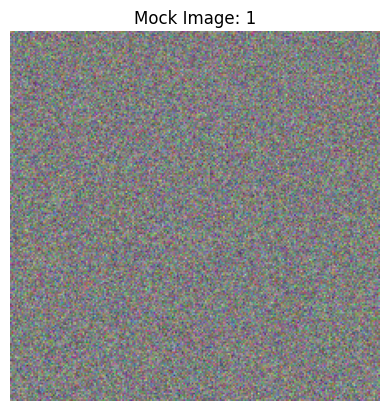

In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Instantiate the dataset
dataset = MockImageDataset(num_samples=1)  # Just generate 1 sample

# Get the image and label
image, label = dataset[0]

# Convert the image tensor to a format matplotlib can display
# PyTorch image shape: (channels, height, width)
# Matplotlib expects: (height, width, channels)
image_np = image.permute(1, 2, 0).numpy()

# Normalize image data to [0, 1] range for display
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Plot the image
plt.imshow(image_np)
plt.title(f"Mock Image: {label.item()}")
plt.axis('off')
plt.show()


# Synthetic Media Generator 

#### Proof of Concept

Generates 2 seconds of synthetic video, audio, and transcript in NPY format.


"""
Generating 2.0s of synthetic media...
Video: 60 frames at 30 FPS
Audio: 88200 samples at 44100 Hz

Files saved:
- synthetic_media_video.npy: (60, 480, 640, 3) (uint8)
- synthetic_media_audio.npy: (88200, 2) (float32)
- synthetic_media_transcript.npy: (3,) ([('timestamp', '<f4'), ('text', '<U50')])

Memory usage: 53.41 MB total

✓ Synthetic media generation complete!

To load and verify the files:
video = np.load('synthetic_media_video.npy')
audio = np.load('synthetic_media_audio.npy')
transcript = np.load('synthetic_media_transcript.npy')
"""

In [14]:


import numpy as np
import math


class SyntheticMediaGenerator:
    """
    Single responsibility: Generate synthetic media components.
    Follows SOLID principles with clear separation of concerns.
    """
    
    def __init__(self):
        # Video parameters
        self.fps = 30
        self.duration = 2.0  # seconds
        self.width = 640
        self.height = 480
        self.channels = 3  # RGB
        
        # Audio parameters  
        self.sample_rate = 44100
        self.audio_channels = 2  # Stereo
        
        # Derived parameters
        self.total_frames = int(self.fps * self.duration)
        self.total_audio_samples = int(self.sample_rate * self.duration)
    
    def generate_video(self) -> np.ndarray:
        """
        Generate synthetic video frames with animated gradient.
        
        Returns:
            np.ndarray: Video array of shape (frames, height, width, channels)
        """
        video = np.zeros((self.total_frames, self.height, self.width, self.channels), 
                        dtype=np.uint8)
        
        for frame_idx in range(self.total_frames):
            # Create animated gradient based on frame number
            t = frame_idx / self.total_frames
            
            # Generate RGB channels with different frequencies
            for y in range(self.height):
                for x in range(self.width):
                    # Normalized coordinates
                    nx, ny = x / self.width, y / self.height
                    
                    # Animated color patterns
                    r = int(127 * (1 + math.sin(2 * math.pi * (nx + t))))
                    g = int(127 * (1 + math.sin(2 * math.pi * (ny + t * 0.7))))
                    b = int(127 * (1 + math.sin(2 * math.pi * (nx * ny + t * 1.3))))
                    
                    video[frame_idx, y, x] = [r, g, b]
        
        return video
    
    def generate_audio(self) -> np.ndarray:
        """
        Generate synthetic stereo audio with sine waves.
        
        Returns:
            np.ndarray: Audio array of shape (samples, channels)
        """
        audio = np.zeros((self.total_audio_samples, self.audio_channels), 
                        dtype=np.float32)
        
        # Time array
        t = np.linspace(0, self.duration, self.total_audio_samples)
        
        # Left channel: 440 Hz tone (A4)
        audio[:, 0] = 0.3 * np.sin(2 * np.pi * 440 * t)
        
        # Right channel: 554.37 Hz tone (C#5)
        audio[:, 1] = 0.3 * np.sin(2 * np.pi * 554.37 * t)
        
        # Apply fade in/out to avoid clicks
        fade_samples = int(0.1 * self.sample_rate)  # 100ms fade
        fade_in = np.linspace(0, 1, fade_samples)
        fade_out = np.linspace(1, 0, fade_samples)
        
        audio[:fade_samples] *= fade_in[:, np.newaxis]
        audio[-fade_samples:] *= fade_out[:, np.newaxis]
        
        return audio
    
    def generate_transcript(self) -> np.ndarray:
        """
        Generate synthetic transcript with timestamps.
        
        Returns:
            np.ndarray: Structured array with timestamps and text
        """
        # Define transcript entries
        transcript_data = [
            (0.0, "Hello, this is a synthetic video demonstration."),
            (1.0, "The colors are changing procedurally over time."),
            (2.0, "End of two-second demonstration.")
        ]
        
        # Create structured array
        dtype = [('timestamp', 'f4'), ('text', 'U50')]
        transcript = np.array(transcript_data, dtype=dtype)
        
        return transcript
    
    def save_all_media(self, prefix: str = "synthetic_media") -> None:
        """
        Generate and save all media components as NPY files.
        
        Args:
            prefix: Filename prefix for output files
        """
        print(f"Generating {self.duration}s of synthetic media...")
        print(f"Video: {self.total_frames} frames at {self.fps} FPS")
        print(f"Audio: {self.total_audio_samples} samples at {self.sample_rate} Hz")
        
        # Generate media
        video = self.generate_video()
        print(video)
        audio = self.generate_audio() 
        print(audio)
        transcript = self.generate_transcript()
        print(transcript)
        
        # Save as NPY files
        np.save(f"{prefix}_video.npy", video)
        np.save(f"{prefix}_audio.npy", audio)
        np.save(f"{prefix}_transcript.npy", transcript)
        
        print(f"\nFiles saved:")
        print(f"- {prefix}_video.npy: {video.shape} ({video.dtype})")
        print(f"- {prefix}_audio.npy: {audio.shape} ({audio.dtype})")
        print(f"- {prefix}_transcript.npy: {transcript.shape} ({transcript.dtype})")
        
        # Memory usage estimation
        video_mb = video.nbytes / (1024 * 1024)
        audio_mb = audio.nbytes / (1024 * 1024)
        total_mb = video_mb + audio_mb
        print(f"\nMemory usage: {total_mb:.2f} MB total")


def main():
    """Main execution function."""
    generator = SyntheticMediaGenerator()
    generator.save_all_media()
    
    print("\n✓ Synthetic media generation complete!")
    print("\nTo load and verify the files:")
    print("video = np.load('synthetic_media_video.npy')")
    print("audio = np.load('synthetic_media_audio.npy')")
    print("transcript = np.load('synthetic_media_transcript.npy')")


if __name__ == "__main__":
    main()

Generating 2.0s of synthetic media...
Video: 60 frames at 30 FPS
Audio: 88200 samples at 44100 Hz
[[[[127 127 127]
   [128 127 127]
   [129 127 127]
   ...
   [123 127 127]
   [124 127 127]
   [125 127 127]]

  [[127 128 127]
   [128 128 127]
   [129 128 127]
   ...
   [123 128 128]
   [124 128 128]
   [125 128 128]]

  [[127 130 127]
   [128 130 127]
   [129 130 127]
   ...
   [123 130 130]
   [124 130 130]
   [125 130 130]]

  ...

  [[127 122 127]
   [128 122 128]
   [129 122 129]
   ...
   [123 122 118]
   [124 122 119]
   [125 122 120]]

  [[127 123 127]
   [128 123 128]
   [129 123 129]
   ...
   [123 123 119]
   [124 123 121]
   [125 123 122]]

  [[127 125 127]
   [128 125 128]
   [129 125 129]
   ...
   [123 125 121]
   [124 125 122]
   [125 125 124]]]


 [[[140 136 144]
   [141 136 144]
   [142 136 144]
   ...
   [136 136 144]
   [137 136 144]
   [139 136 144]]

  [[140 137 144]
   [141 137 144]
   [142 137 144]
   ...
   [136 137 145]
   [137 137 145]
   [139 137 145]]

  [[1